In [1]:
%matplotlib nbagg
import numpy as np
import json
import h5py
import matplotlib.pyplot as plt
import scipy
from scipy.special import erf
from scipy.optimize import curve_fit
import os
import sys

In [17]:
channel_pulse_ids      = "SLAAR11-LMOT-M451:ENC_1_BS/pulse_id"           #Pulse ids taken from pump-probe delay stage (100 Hz)

In [18]:
def LoadData_YAG(filename):
    with h5py.File(filename, 'r') as BS_file:
        pulse_ids = BS_file[channel_pulse_ids][:]
        
        FEL = BS_file[channel_Events][:,48]
        Laser = BS_file[channel_Events][:,18]
        Darkshot = BS_file[channel_Events][:,21]
        
        index_pump = np.logical_and(FEL, Laser, np.logical_not(Darkshot))
        index_unpump = np.logical_and(np.logical_not(FEL), Laser, np.logical_not(Darkshot))
    
        LaserDiode_pump = BS_file[channel_LaserDiode][:][index_pump]
        LaserDiode_unpump = BS_file[channel_LaserDiode][:][index_unpump]
        LaserRefDiode_pump = BS_file[channel_Laser_refDiode][:][index_pump]
        LaserRefDiode_unpump = BS_file[channel_Laser_refDiode][:][index_unpump]
        
        Izero_pump = BS_file[channel_Izero][:][index_pump]
        Izero_unpump = BS_file[channel_Izero][:][index_unpump]
        PIPS = BS_file[channel_PIPS_trans][:][index_pump]
        
        Delay = BS_file[channel_delay][:][index_unpump]
        #Delay = BS_file[channel_laser_pitch][:][index_unpump]
        
        BAM = BS_file[channel_BAM][:][index_unpump]
        
    return LaserDiode_pump, LaserDiode_unpump, Izero_pump, Izero_unpump, PIPS, LaserRefDiode_pump,LaserRefDiode_unpump,Delay, BAM, pulse_ids

def errfunc(x, a, b, c, d):
    return a + b*erf((c-x)*2*np.sqrt(np.log(2))/(np.abs(d)))

In [19]:
#scan_name ="YAG_FEL0.1_laser11uJ_003"
#scan_name ="YAG_FEL0.20_2505_010"
#scan_name ="Overlap_pitch_ref_008"
scan_name ="YAG_with_scansJF"

#DIR = "/sf/alvra/data/p17807/res/scan_data/" + scan_name + "/"
DIR = "/sf/alvra/data/p17807/raw/scan_data/" + scan_name + "/"
#DIR = "/sf/alvra/data/p17803/res/scan_data/" + scan_name + "/"
DIR_json = "/sf/alvra/data/p17807/res/scan_info/"



In [20]:
!ls -la -rt $DIR


!hostname

listfile = os.listdir(DIR)
number_files = len(listfile)
print ("There are",number_files,"files in the folder", DIR)

total 9281154
-rw-r--r--. 1 17807 p17807 838941200 May 26 22:43 YAG_with_scansJF_step0000.JF06T08V01.h5
-rw-r--r--. 1 17807 p17807 838941200 May 26 22:43 YAG_with_scansJF_step0001.JF06T08V01.h5
-rw-r--r--. 1 17807 p17807 838941200 May 26 22:43 YAG_with_scansJF_step0002.JF06T08V01.h5
-rw-r--r--. 1 17807 p17807 838941200 May 26 22:43 YAG_with_scansJF_step0003.JF06T08V01.h5
-rw-r--r--. 1 root  p17807     10472 May 26 22:43 YAG_with_scansJF_step0000.BSREAD_CA.h5
-rw-r--r--. 1 17807 p17807 838941200 May 26 22:43 YAG_with_scansJF_step0004.JF06T08V01.h5
-rw-r--r--. 1 root  p17807      9656 May 26 22:43 YAG_with_scansJF_step0001.BSREAD_CA.h5
-rw-r--r--. 1 root  p17807      9920 May 26 22:43 YAG_with_scansJF_step0002.BSREAD_CA.h5
-rw-r--r--. 1 17807 p17807 838941200 May 26 22:43 YAG_with_scansJF_step0005.JF06T08V01.h5
-rw-r--r--. 1 root  p17807      9896 May 26 22:43 YAG_with_scansJF_step0003.BSREAD_CA.h5
-rw-r--r--. 1 17807 p17807 838941200 May 26 22:44 YAG_with_scansJF_step0006.JF06T08V01.h5


In [21]:
json_file = DIR_json + scan_name + "_scan_info.json"

print (json_file)

with open(json_file) as file:
    data = json.load(file)
numFiles = len(data['scan_files'])
#numFiles = 1

print ("Processing",numFiles,"files")
print (json_file)

Laser_diff = []
err_laser_diff =[]

Izero_pump = []
err_Izero_pump = []
Izero_pump_all = []
Izero_pump_all_filter = []

PIPS = []
Laser_ref = []
Delay_mm = []
BAM = []
BAM_error = []

for i in range(0,numFiles):
#for i in range(30,31):
    filename = str(data['scan_files'][i][0])
    exists = os.path.isfile(filename)

    if (exists) & (i!=1):
        print("step",i+1,"of",numFiles,": Processing %s" % (str(data['scan_files'][i][0])))
        (Laser_pump_loop,Laser_unpump_loop,Izero_pump_loop,Izero_unpump_loop,PIPS_loop,Laser_ref_pump_loop,Laser_ref_unpump_loop,delay_loop,BAM_loop, pids_loop) = LoadData_YAG(str(data['scan_files'][i][0]))
        
        # I added a condition on the Laser_ref to avoid negative numbers and a little higher condition number to protect 
        # from the no intensity dark shots  ... greg
        threshold_pump = Izero_pump_loop > 0.1
        condition_pump = Izero_pump_loop >  np.median(Izero_pump_loop)-2*(np.std(Izero_pump_loop))
        condition_laser_pump = ((Laser_pump_loop > 10) & (Laser_ref_pump_loop > 100))
        condition_laser_unpump = ((Laser_unpump_loop > 10) & (Laser_ref_unpump_loop > 100))
        #condition_laser_ref_pump = Laser_ref_pump_loop > 10
        #condition_laser_ref_unpump = Laser_ref_unpump_loop > 10

        Laser_pump_loop = Laser_pump_loop[condition_pump & threshold_pump & condition_laser_pump & condition_laser_unpump]
        Laser_unpump_loop = Laser_unpump_loop[condition_pump & threshold_pump & condition_laser_pump & condition_laser_unpump]
        Laser_ref_pump_loop = Laser_ref_pump_loop[condition_pump & threshold_pump & condition_laser_pump & condition_laser_unpump]
        Laser_ref_unpump_loop = Laser_ref_unpump_loop[condition_pump & threshold_pump & condition_laser_pump & condition_laser_unpump]
        Izero_pump_loop_filter = Izero_pump_loop[condition_pump & threshold_pump & condition_laser_pump & condition_laser_unpump]
        
        Laser_diff_loop = -np.log10((Laser_pump_loop/Laser_ref_pump_loop) / (Laser_unpump_loop/ Laser_ref_unpump_loop))#/Izero_pump_loop_filter
        #Laser_diff_loop = -np.log10((Laser_pump_loop) / (Laser_unpump_loop))#/Izero_pump_loop_filter
        Laser_diff.append(Laser_diff_loop.mean())
        err_laser_diff.append(Laser_diff_loop.std()/np.sqrt(Laser_diff_loop.size))
        
        Izero_pump_all.append(Izero_pump_loop)
        Izero_pump_all_filter.append(Izero_pump_loop_filter)
        Izero_pump.append(Izero_pump_loop_filter.mean())
        err_Izero_pump.append(Izero_pump_loop.std()/np.sqrt(Izero_pump_loop_filter.size))
        
        PIPS.append(PIPS_loop.mean())
        #Laser_ref.append(Laser_ref_loop.mean())
        #Delay_mm.append(delay_loop.mean())
        Delay_mm.append(delay_loop[0])
        BAM.append(BAM_loop.mean())
        BAM_error.append(BAM_loop.std()/np.sqrt(BAM_loop.size))

Laser_diff = np.asarray(Laser_diff)
err_laser_diff = np.asarray(err_laser_diff)

Izero_pump = np.asarray(Izero_pump)
err_Izero_pump = np.asarray(err_Izero_pump)

Izero_total_1D = np.hstack(Izero_pump_all)
Izero_total_1D_filter = np.hstack(Izero_pump_all_filter)


Delay_mm = np.asarray(Delay_mm)
BAM = np.asarray(BAM)
BAM_error = np.asarray(BAM_error)

/sf/alvra/data/p17807/res/scan_info/YAG_with_scansJF_scan_info.json
Processing 11 files
/sf/alvra/data/p17807/res/scan_info/YAG_with_scansJF_scan_info.json
step 1 of 11 : Processing /sf/alvra/data/p17807/raw/scan_data/YAG_with_scansJF/YAG_with_scansJF_step0000.BSREAD.h5


KeyError: 'Unable to open object (component not found)'

[0.98965881 0.97565306 0.99833414 1.00784326 1.04244056 1.01232713
 1.03452881 1.0060906  0.99406605 0.99828963 0.97863427 1.01146628
 0.98663862 0.98067028 0.99153678 0.98772767 0.9647444  1.01429642
 0.99752111 0.97977937 0.97380935 0.97532245 0.98269983 1.00496189
 1.00307728 0.98019054 1.0157242  0.98169481 0.97424372 1.01189428
 1.02840174 1.00388592 1.03798907 0.99668331 1.02120981 0.98435883
 1.02126026 1.00353575 1.01230233 0.94742282 0.99454728 1.00251668
 1.00110366 1.00257843 1.00351232 0.99108888 0.97354392 0.98949417
 0.9520519  1.01124172 1.01415014 0.99559855 1.0538187  0.95846054
 0.96233829 0.99194209 1.04064517 0.98022413 1.00058793 1.04510365
 0.95510937 1.0361394  1.01175586 1.02519718 0.99963549 1.00334589
 1.0018441  1.04209665 1.04131799 1.0329994  0.98968817 0.9972445
 0.98853333 1.03926742 1.02258642 0.98955419 1.02774446 0.97571893
 1.01994301 1.02533291 0.96750554 0.97309736 0.9996522  0.99559569
 1.01661639 1.03733059 0.99650443 1.00655199 0.98442745 1.01416

<IPython.core.display.Javascript object>


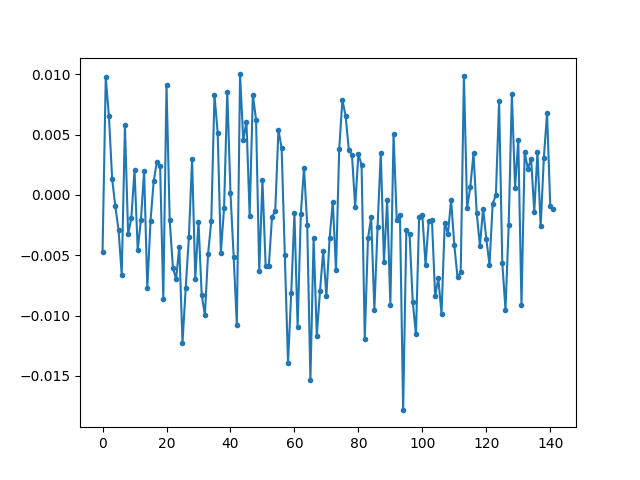

In [90]:
# Just testing stuff ... g. 
#print(Izero_pump_loop)
#print(np.std(Izero_pump_loop))
#print(condition_laser_unpump)
print(Laser_ref_pump_loop/Laser_ref_unpump_loop)
#len(Laser_diff)
plt.figure()
#plt.plot(Laser_ref_pump_loop/Laser_ref_unpump_loop, marker='.')
plt.plot(-np.log10(Laser_pump_loop/Laser_unpump_loop), marker='.')


Total shots= 7500 // filtered=, 6940


<IPython.core.display.Javascript object>


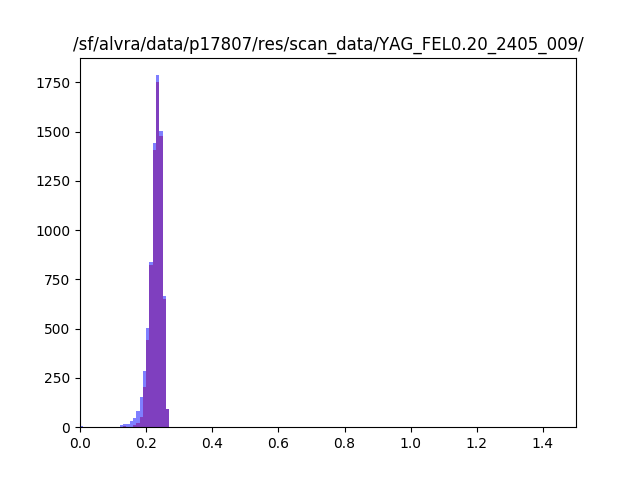

In [88]:
# Check if the condition on the intensity makes sense by looking at the total histogram. 

num_bins = 100
print ("Total shots=",Izero_total_1D.size,"// filtered=,",Izero_total_1D_filter.size)
plt.figure()
plt.hist(Izero_total_1D_filter, bins =np.arange(0,1.5,0.01), facecolor='red', alpha=0.5)
plt.hist(Izero_total_1D, bins =np.arange(0,1.5,0.01), facecolor='blue', alpha=0.5)
#plt.hist(Izero_pump_loop_filter, bins =np.arange(0,1.5,0.01), facecolor='blue', alpha=0.5)

#plt.hist(Izero_pump_loop, num_bins, facecolor='blue', alpha=0.5)
#plt.hist(Izero_pump_loop_filter, num_bins, facecolor='orange', alpha=0.5)
plt.xlim(0,1.5)
plt.title(DIR)

plt.show()

<IPython.core.display.Javascript object>


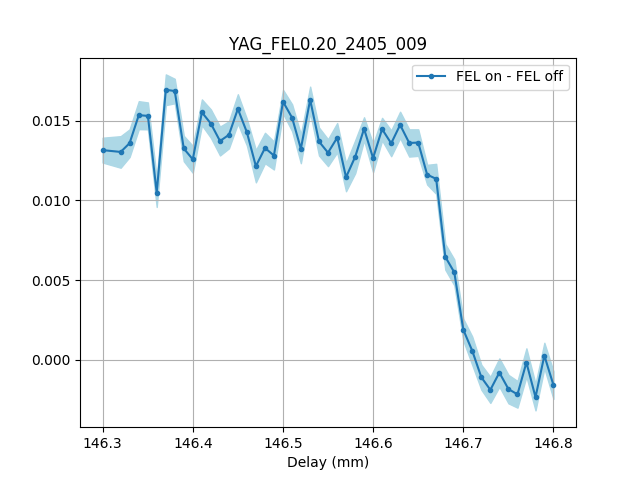

In [89]:
# Plot pump probe signal as a function of delay (stage mm)

#savedir = "/das/work/p17/p17569/Beamline/"
plt.figure()
plt.plot(Delay_mm, Laser_diff, label="FEL on - FEL off",marker='.')

low_err= Laser_diff - err_laser_diff
high_err= Laser_diff + err_laser_diff
plt.fill_between(np.squeeze(Delay_mm), low_err, high_err, color='lightblue')

plt.title(scan_name)
plt.xlabel("Delay (mm)")
plt.legend(loc="best")
plt.grid()
plt.show()
#plt.savefig(savedir + 'LAMcheck_026')


<IPython.core.display.Javascript object>


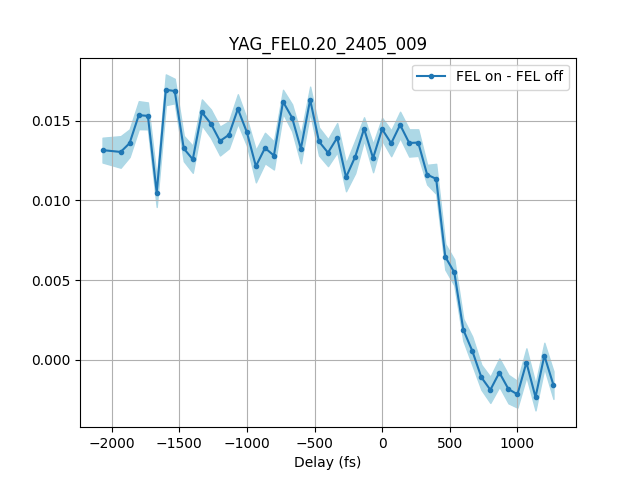

In [94]:
# Plot pump probe signal as a function of time (fs)

#savedir = "/das/work/p17/p17569/Beamline/"

Delay_ps = 2* (Delay_mm - 146.61)*3.333   # factor of 2 in delay due to the delay stage

plt.figure()
plt.plot((Delay_ps)*1000, Laser_diff, label="FEL on - FEL off",marker='.')   

low_err= Laser_diff - err_laser_diff
high_err= Laser_diff + err_laser_diff
plt.fill_between(np.squeeze((Delay_ps)*1000), low_err, high_err, color='lightblue')

plt.title(scan_name)
plt.xlabel("Delay (fs)")
plt.legend(loc="best")
plt.grid()
plt.show()
#plt.savefig('Timescan_7_diode')

In [95]:
#RUN THIS FOR THE FIT !!!

Delay_mm_toFit = Delay_mm.copy()
Delay_ps_toFit = Delay_ps.copy()
Laser_diff_toFit = Laser_diff.copy()

In [96]:
# Now fit with error funciton (defined above)
parameters,extras = curve_fit(errfunc, Delay_ps_toFit, Laser_diff_toFit, p0 = [0.02, 1, 0, 0.05])

print("Position t0 =",np.round(parameters[2],5)*1000,"fs")
print("Width =",np.abs(np.round(parameters[3],3))*1000,"fs")

Position t0 = 496.47 fs
Width = 319.0 fs


<IPython.core.display.Javascript object>


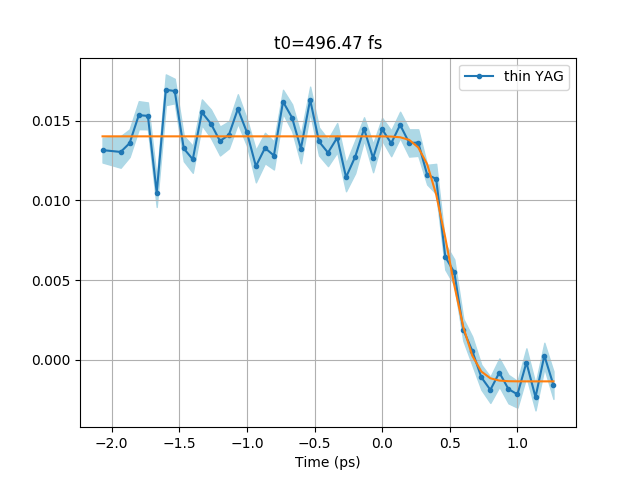

In [97]:
#... and the plot with the fit curve

#savedir = "/das/work/p17/p17569/Beamline/"

plt.figure()

plt.plot(Delay_ps_toFit, Laser_diff_toFit, label="thin YAG",marker='.')
plt.plot(Delay_ps_toFit, errfunc(Delay_ps_toFit,*parameters))

#low_err= signal_norm - err_signal_norm
#high_err= signal_norm + err_signal_norm

plt.fill_between(Delay_ps_toFit, low_err, high_err, color='lightblue')
plt.title('t0=' + str(np.round(parameters[2], 5)*1000) + ' fs' )
plt.grid()
plt.xlabel("Time (ps)")
plt.legend(loc="best")
plt.show()
#plt.savefig(savedir + 'scan_YAG_007')

In [391]:
Laser_diff_1000_4 = Laser_diff.copy()
Delay_mm_1000_4 = Delay_mm.copy()
Delay_ps_1000_4 = Delay_ps.copy()

<IPython.core.display.Javascript object>


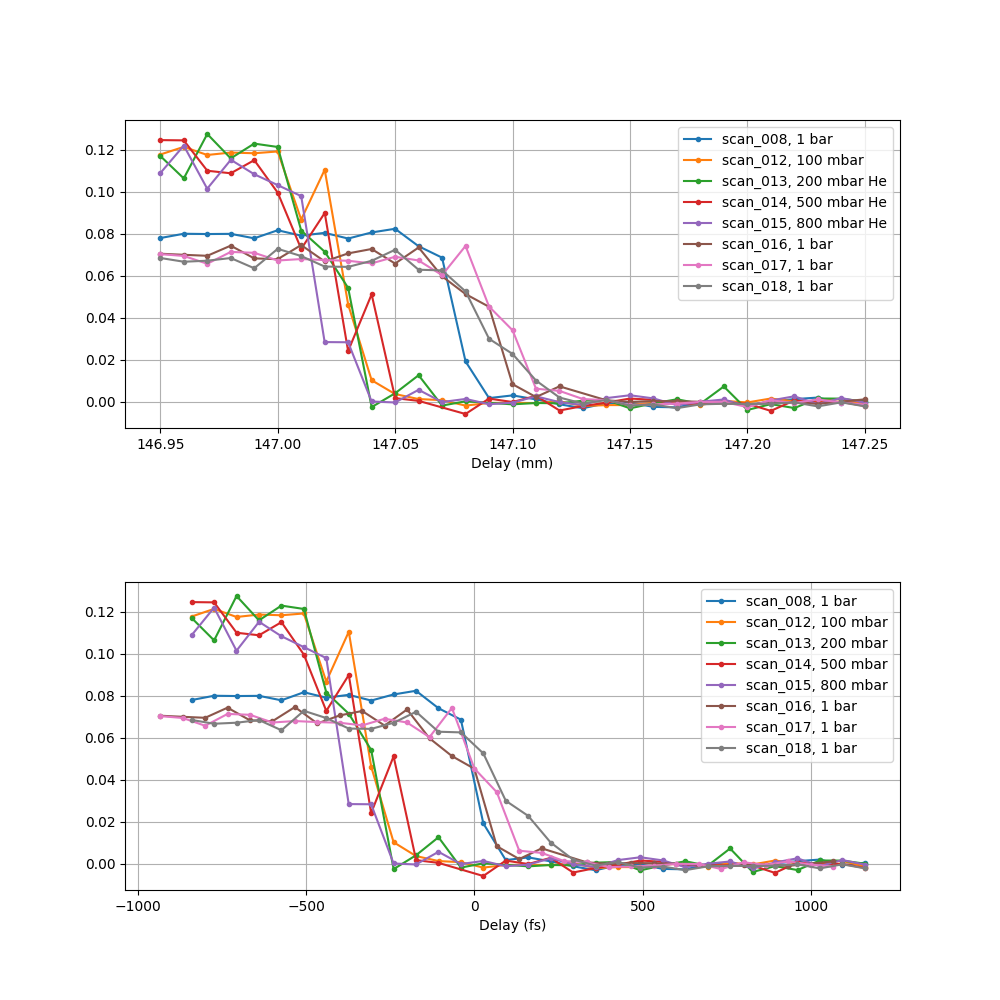

In [392]:
plt.figure(figsize=(10,10))
plt.subplots_adjust(hspace=0.5)

plt.subplot(211)
plt.plot(Delay_mm_1000, Laser_diff_1000, label="scan_008, 1 bar",marker='.')
#plt.plot(Delay_mm_800, Laser_diff_800, label="scan_009, 800 mbar",marker='.')
#plt.plot(Delay_mm_500, Laser_diff_500, label="scan_010, 500 mbar",marker='.')
#plt.plot(Delay_mm_200, Laser_diff_200, label="scan_011, 200 mbar",marker='.')
plt.plot(Delay_mm_100, Laser_diff_100, label="scan_012, 100 mbar",marker='.')
plt.plot(Delay_mm_200He, Laser_diff_200He, label="scan_013, 200 mbar He",marker='.')
plt.plot(Delay_mm_500He, Laser_diff_500He, label="scan_014, 500 mbar He",marker='.')
plt.plot(Delay_mm_800He, Laser_diff_800He, label="scan_015, 800 mbar He",marker='.')
plt.plot(Delay_mm_1000_2, Laser_diff_1000_2, label="scan_016, 1 bar",marker='.')
plt.plot(Delay_mm_1000_3, Laser_diff_1000_3, label="scan_017, 1 bar",marker='.')
plt.plot(Delay_mm_1000_4, Laser_diff_1000_4, label="scan_018, 1 bar",marker='.')

#plt.plot(Delay_mm_toFit, errfunc(Delay_mm_toFit,*parameters))

#low_err= signal_norm - err_signal_norm
#high_err= signal_norm + err_signal_norm

#plt.fill_between(Delay_mm_toFit, low_err, high_err, color='lightblue')
#plt.title(np.round(parameters[2], 3) )
plt.grid()
plt.xlabel("Delay (mm)")
plt.legend(loc="best")

plt.subplot(212)

plt.plot(2*Delay_ps_1000*1000, Laser_diff_1000, label="scan_008, 1 bar",marker='.')
#plt.plot(2*Delay_ps_800*1000, Laser_diff_800, label="scan_009, 800 mbar",marker='.')
#plt.plot(2*Delay_ps_500*1000, Laser_diff_500, label="scan_010, 500 mbar",marker='.')
#plt.plot(2*Delay_ps_200*1000, Laser_diff_200, label="scan_011, 200 mbar",marker='.')
plt.plot(2*Delay_ps_100*1000, Laser_diff_100, label="scan_012, 100 mbar",marker='.')
plt.plot(2*Delay_ps_200He*1000, Laser_diff_200He, label="scan_013, 200 mbar",marker='.')
plt.plot(2*Delay_ps_500He*1000, Laser_diff_500He, label="scan_014, 500 mbar",marker='.')
plt.plot(2*Delay_ps_800He*1000, Laser_diff_800He, label="scan_015, 800 mbar",marker='.')
plt.plot(2*Delay_ps_1000_2*1000, Laser_diff_1000_2, label="scan_016, 1 bar",marker='.')
plt.plot(2*Delay_ps_1000_3*1000, Laser_diff_1000_3, label="scan_017, 1 bar",marker='.')
plt.plot(2*Delay_ps_1000_4*1000, Laser_diff_1000_4, label="scan_018, 1 bar",marker='.')
#plt.plot(Delay_mm_toFit, errfunc(Delay_mm_toFit,*parameters))


#low_err= signal_norm - err_signal_norm
#high_err= signal_norm + err_signal_norm

#plt.fill_between(Delay_mm_toFit, low_err, high_err, color='lightblue')
#plt.title(np.round(parameters[2], 3) )
plt.grid()
plt.xlabel("Delay (fs)")
plt.legend(loc="best")

plt.show()
#plt.savefig(savedir + 'scan_YAG_007')

<IPython.core.display.Javascript object>


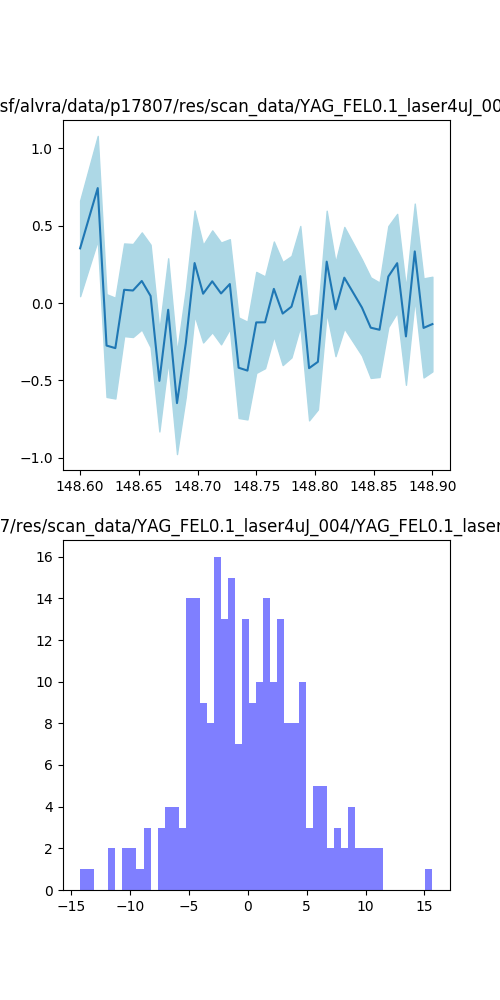

In [25]:
num_bins = 50

plt.figure(figsize=(5,10))

plt.subplot(211)
plt.plot(Delay_mm, BAM)
low_err = BAM - BAM_error
high_err = BAM + BAM_error
plt.fill_between(np.squeeze(Delay_mm), low_err, high_err, color='lightblue')
plt.title(DIR)

plt.subplot(212)
plt.hist(BAM_loop, num_bins, facecolor='blue', alpha=0.5)
plt.title(filename)

plt.show()

## Next cell  just to calculate time zero 

In [9]:
time_zero = 146.56     #this is in mm from the delay scans

desidered_delay = 0.600
#choose this in ps

delay_to_set = (100/(2*333))*desidered_delay + time_zero        #factor of 2 because of the delay stage

desidered_delay + time_zero
print ("To be at",desidered_delay,"ps, put the laser pump delay stage to",np.round(delay_to_set,4),"mm")

To be at 0.6 ps, put the laser pump delay stage to 146.6501 mm


In [8]:
offset_space = 22       # this is in um

offset_time = 2*(offset_space * 1e-6)/3e8/1e-15            #factor of 2 because of the delay stage, results in fs
print ("An offset of",offset_space,"um corresponds to an offset of",np.round(offset_time,4),"fs")

An offset of 22 um corresponds to an offset of 146.6667 fs


In [3]:
offset_time = 5000      # this is in fs

offset_space = 3e8 * (offset_time * 1e-15)/2/1e-6          #factor of 2 because of the delay stage, results in um
print ("An offset of",offset_time,"fs corresponds to an offset of",np.round(offset_space,4),"um")

An offset of 5000 fs corresponds to an offset of 750.0 um


In [117]:
saveDir = "/das/work/p17/p17589/Gregor/"   # dest folder (needs to exist)
fn = str(saveDir + "yag_longscan_xy.h5")
hf = h5py.File(fn, 'w')
hf.create_dataset('Position_mm', data = Delay_mm)
hf.create_dataset('Laser_diff', data = Laser_diff)
hf.close()


In [115]:
saveDir

'das/work/p17/p17589/Gregor/'

In [7]:
146.5822 - 146.56

0.022199999999998

In [5]:
50/4.17


11.990407673860911